# Secondary standard stars


Processing: phot_00.fits
  Optimal Aperture: 25 px

Processing: phot_01.fits
  Optimal Aperture: 27 px

Processing: phot_02.fits
  Optimal Aperture: 26 px

Processing: phot_03.fits
  Optimal Aperture: 26 px

Processing: phot_04.fits
  Optimal Aperture: 27 px

Processing: phot_05.fits
  Optimal Aperture: 25 px

Processing: phot_06.fits
  Optimal Aperture: 26 px

Processing: phot_07.fits
  Optimal Aperture: 30 px

Processing: phot_08.fits
  Optimal Aperture: 33 px

Processing: phot_09.fits
  Optimal Aperture: 29 px

Processing: phot_10.fits
  Optimal Aperture: 29 px

Processing: phot_11.fits
  Optimal Aperture: 30 px

Processing: phot_12.fits
  Optimal Aperture: 30 px

Processing: phot_13.fits
  Optimal Aperture: 29 px

Processing: phot_14.fits
  Optimal Aperture: 29 px

Processing: phot_15.fits
  Optimal Aperture: 28 px

Processing: phot_16.fits
  Optimal Aperture: 16 px

Processing: phot_17.fits
  Optimal Aperture: 17 px

Calibrating: phot_00.fits
  Calibration Summary:
    star1:
   

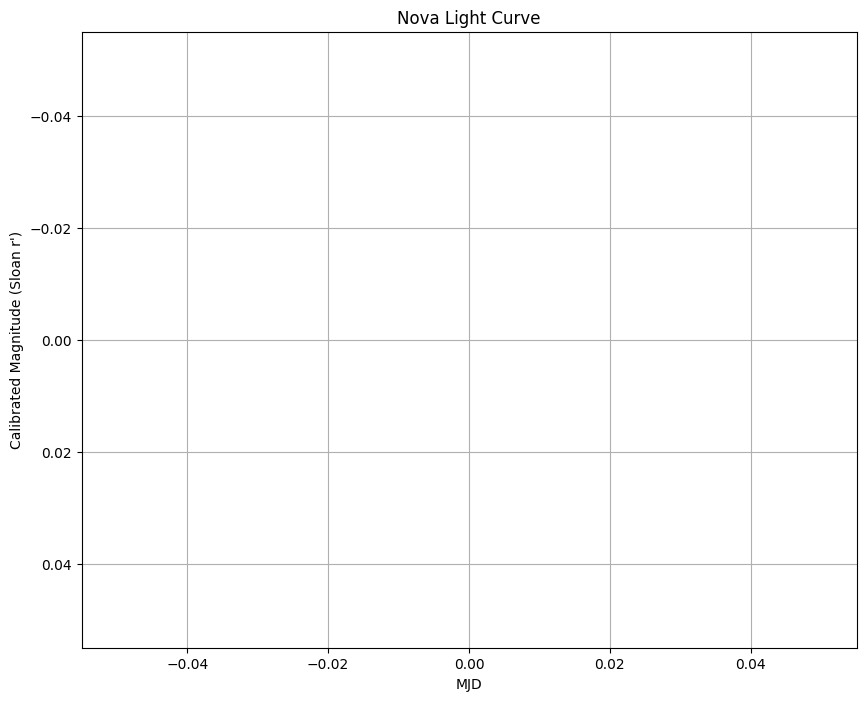

Photometry results saved to C:\Users\friesco\workstation\fr-p\studies\ASTRO716\data_excercise\photometry_results.csv


In [19]:
import astropy
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
import numpy as np
import os
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from astroquery.gaia import Gaia
from astropy.wcs import WCS
import warnings
from astropy.wcs import FITSFixedWarning
import pandas as pd

warnings.filterwarnings('ignore', category=FITSFixedWarning, message=".*'datfix' made the change.*")

# --- Configuration ---
wd = r"C:\Users\friesco\workstation\fr-p\studies\ASTRO716\data_excercise"  # Your working directory
plt.rcParams['figure.figsize'] = [10, 8]

# --- Functions ---
def phot_counts(img, nx, ny, ap_rad, in_ann, out_ann):
    ap = CircularAperture((nx, ny), r=ap_rad)
    ann_ap = CircularAnnulus((nx, ny), r_in=in_ann, r_out=out_ann)
    phot_tbl = aperture_photometry(img, [ap, ann_ap])

    ann_mask = ann_ap.to_mask(method='center')
    ann_data = ann_mask.multiply(img)
    bkg_vals = ann_data[ann_mask.data > 0]
    mean, med, std = sigma_clipped_stats(bkg_vals, sigma=3.0)
    bkg_med = med
    bkg_sum = bkg_med * ap.area

    tot_counts = phot_tbl['aperture_sum_0'][0]
    return tot_counts, bkg_sum, ap.area

def calc_snr(tot_counts, bkg_counts, ap_area):
    mean_counts = (tot_counts - bkg_counts) / ap_area
    if tot_counts + bkg_counts <= 0:
        print("Warning: Negative counts. Returning SNR = 0")
        return 0.0
    err_counts = np.sqrt(tot_counts + bkg_counts) / ap_area
    return mean_counts / err_counts

def phot_mag(img, x, y, ap_rad, in_ann, out_ann):
    ap = CircularAperture((x, y), r=ap_rad)
    ann_ap = CircularAnnulus((x, y), r_in=in_ann, r_out=out_ann)
    phot_tbl = aperture_photometry(img, [ap, ann_ap])

    ann_mask = ann_ap.to_mask(method='center')
    ann_data = ann_mask.multiply(img)
    bkg_vals = ann_data[ann_mask.data > 0]
    mean, med, std = sigma_clipped_stats(bkg_vals, sigma=3.0)
    bkg_med = med
    bkg_sum = bkg_med * ap.area

    final_sum = phot_tbl['aperture_sum_0'] - bkg_sum
    if final_sum[0] > 0:
        inst_mag = -2.5 * np.log10(final_sum) + 50
        mag_err = 1.0857 * (np.sqrt(phot_tbl['aperture_sum_0'] + bkg_sum) / phot_tbl['aperture_sum_0'])
    else:
        inst_mag = np.nan
        mag_err = np.nan
    return inst_mag, mag_err, bkg_med

# --- Load PS1 Catalog ---
ps1_cat = pd.read_csv(os.path.join(wd, 'psdr1_new.tsv'), sep='\t')

# --- Coordinates of Nova and Secondary Stars ---
nx, ny = 1033, 1336
nova_coords = (nx, ny)
# I have already identified these stars in SIMBAD and GAIA in previous code, I will use them here
sec_stars = {
    'star1': {'coords': (820, 165), 'simbad_name': None, 'gaia_id': None},
    'star2': {'coords': (1795, 520), 'simbad_name': 'UCAC4 652-002852', 'gaia_id': 'Gaia DR2 253173357752927360'},
    'star3': {'coords': (935, 565), 'simbad_name': '2MASS J00443001+4007595', 'gaia_id': 'Gaia DR2 253122059951879040'},
    'star4': {'coords': (745, 1315), 'simbad_name': None, 'gaia_id': None},
    'star5': {'coords': (935, 1020), 'simbad_name': None, 'gaia_id': None}
}

# --- Photometry Parameters ---
ap_radii_snr = np.arange(5, 41, 1)
in_ann, out_ann = 25, 35

# --- Get Optimal Apertures for Each Image ---
phot_files = [f for f in os.listdir(wd) if f.startswith('phot_') and f.endswith('.fits')]
phot_files.sort()
opt_ap = []

for i, f in enumerate(phot_files):
    path = os.path.join(wd, f)
    with fits.open(path) as hdu:
        img = hdu[0].data
        if img.dtype.byteorder == '>':
            img = img.byteswap().view(img.dtype.newbyteorder('<'))

    print(f"\nProcessing: {f}")
    snrs = []
    for ap_rad in ap_radii_snr:
        tot_counts, bkg_counts, ap_area = phot_counts(img, nx, ny, ap_rad, in_ann, out_ann)
        if tot_counts + bkg_counts <= 0:
            print(f"Warning: Negative counts in {f}, aperture: {ap_rad}")
            snrs.append(0.0)
        else:
            snr = calc_snr(tot_counts, bkg_counts, ap_area)
            snrs.append(snr)

    opt_ap_rad = ap_radii_snr[np.argmax(snrs)]
    opt_ap.append(opt_ap_rad)
    print(f"  Optimal Aperture: {opt_ap_rad} px")

# --- Perform Photometry and Calibration ---
phot_results = []

for i, f in enumerate(phot_files):
    path = os.path.join(wd, f)
    with fits.open(path) as hdu:
        img = hdu[0].data
        hdr = hdu[0].header
        if img.dtype.byteorder == '>':
            img = img.byteswap().view(img.dtype.newbyteorder('<'))
    wcs = WCS(hdr)

    print(f"\nCalibrating: {f}")
    opt_ap_rad = opt_ap[i]
    image_results = {'image': f, 'mjd': hdr['MJD'], 'nova': {}, 'sec_stars': {}}

    # --- Photometry for Nova ---
    inst_mag, mag_err, bkg_med = phot_mag(img, nx, ny, opt_ap_rad, in_ann, out_ann)
    ra, dec = wcs.pixel_to_world_values(nx, ny)
    image_results['nova'] = {
        'x': nx,
        'y': ny,
        'ra': ra,
        'dec': dec,
        'inst_mag': inst_mag,
        'mag_err': mag_err,
        'bkg': bkg_med
    }

    # --- Photometry and Calibration for Secondary Stars --- (REPLACE EVERYTHING BELOW THIS LINE)
    zp_values = []
    for star_name, star_data in sec_stars.items():
        x, y = star_data['coords']
        inst_mag, mag_err, bkg_med = phot_mag(img, x, y, opt_ap_rad, in_ann, out_ann)
        ra, dec = wcs.pixel_to_world_values(x, y)

        # --- Find PS1 Catalog Magnitude (FIXED) ---
        c = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
        ra_col_names = ["RA", "RAJ2000", "raMean", "ra_mean"]  # Potential RA column names
        dec_col_names = ["DEC", "DEJ2000", "decMean", "dec_mean"] # Potential DEC column names
        matches = pd.DataFrame()  # Initialize an empty DataFrame for matches

        # Iterate through potential RA/DEC column names to find a match
        for ra_col in ra_col_names:
            for dec_col in dec_col_names:
                try:
                    # --- Convert to numeric (THIS IS THE KEY CHANGE) ---
                    ps1_cat[ra_col] = pd.to_numeric(ps1_cat[ra_col], errors='coerce')
                    ps1_cat[dec_col] = pd.to_numeric(ps1_cat[dec_col], errors='coerce')

                    matches = ps1_cat[
                        (np.abs(ps1_cat[ra_col] - c.ra.deg) < 0.0083) &
                        (np.abs(ps1_cat[dec_col] - c.dec.deg) < 0.0083)
                    ]
                    # If matches are found, exit the inner loops
                    if not matches.empty:
                        break
                except KeyError:
                    # Handle the case where a column name doesn't exist
                    pass
            if not matches.empty:
                break  # Exit the outer loop if matches are found

        # If matches are found, process them
        if not matches.empty:
            distances = np.sqrt(
                (matches[ra_col] - c.ra.deg) ** 2 + (matches[dec_col] - c.dec.deg) ** 2
            )
            closest_match = matches.iloc[np.argmin(distances)]

            # Extract r and g magnitudes, handling potential KeyError
            try:
                ps1_r = closest_match['rMeanPSFMag']
            except KeyError:
                ps1_r = np.nan
            try:
                ps1_g = closest_match['gMeanPSFMag']
            except KeyError:
                ps1_g = np.nan
        else:
            print(f"Warning: No PS1 match found for {star_name} in {f}")
            ps1_r, ps1_g = np.nan, np.nan

        # --- Transform PS1 Magnitude to Sloan ---
        if not np.isnan(ps1_r) and not np.isnan(ps1_g):
            sloan_r = ps1_r - 0.001 + 0.011 * (ps1_g - ps1_r)
        else:
            sloan_r = np.nan

        # --- Calculate Magnitude Difference and Zero Point ---
        if not np.isnan(inst_mag) and not np.isnan(sloan_r):
            delta_mag = sloan_r - inst_mag
            zp_values.append(delta_mag)
        else:
            delta_mag = np.nan

        image_results['sec_stars'][star_name] = {
            'x': x,
            'y': y,
            'ra': ra,
            'dec': dec,
            'inst_mag': inst_mag,
            'mag_err': mag_err,
            'bkg': bkg_med,
            'ps1_r': ps1_r,
            'ps1_g': ps1_g,
            'sloan_r': sloan_r,
            'delta_mag': delta_mag
        }

    # --- Calculate Average Zero Point for This Image ---
    if zp_values:
        zp = np.nanmean(zp_values)
        zp_std = np.nanstd(zp_values)
    else:
        zp = np.nan
        zp_std = np.nan

    image_results['zp'] = zp
    image_results['zp_std'] = zp_std

    # --- Calibrate Nova's Magnitude ---
    if not np.isnan(image_results['nova']['inst_mag']) and not np.isnan(zp):
        image_results['nova']['calibrated_mag'] = image_results['nova']['inst_mag'] + zp
    else:
        image_results['nova']['calibrated_mag'] = np.nan

    phot_results.append(image_results)

    # --- Print Calibration Summary ---
    print("  Calibration Summary:")
    for star_name, star_data in image_results['sec_stars'].items():
        print(f"    {star_name}:")

        # --- Handle Formatting of Instrumental Magnitude and Error ---
        if isinstance(star_data['inst_mag'], (int, float)) and not np.isnan(star_data['inst_mag']):
            inst_mag_str = f"{star_data['inst_mag']:.3f}"
        else:
            inst_mag_str = "N/A"

        if isinstance(star_data['mag_err'], (int, float)) and not np.isnan(star_data['mag_err']):
            mag_err_str = f"{star_data['mag_err']:.3f}"
        else:
            mag_err_str = "N/A"

        print(f"      Instrumental Mag: {inst_mag_str} +/- {mag_err_str}")

        # --- Handle Formatting of PS1 r, PS1 g, Sloan r', and Delta Mag ---
        if isinstance(star_data['ps1_r'], (int, float)) and not np.isnan(star_data['ps1_r']):
            print(f"      PS1 r: {star_data['ps1_r']:.3f}")
        else:
            print(f"      PS1 r: N/A")

        if isinstance(star_data['ps1_g'], (int, float)) and not np.isnan(star_data['ps1_g']):
            print(f"      PS1 g: {star_data['ps1_g']:.3f}")
        else:
            print(f"      PS1 g: N/A")

        if isinstance(star_data['sloan_r'], (int, float)) and not np.isnan(star_data['sloan_r']):
            print(f"      Sloan r': {star_data['sloan_r']:.3f}")
        else:
            print(f"      Sloan r': N/A")

        if isinstance(star_data['delta_mag'], (int, float)) and not np.isnan(star_data['delta_mag']):
            print(f"      Delta Mag: {star_data['delta_mag']:.3f}")
        else:
            print(f"      Delta Mag: N/A")

    # --- Handle Formatting of Zero Point (ZP) and Nova's Calibrated Magnitude ---
    if isinstance(zp, (int, float)) and not np.isnan(zp):
        zp_str = f"{zp:.3f}"
    else:
        zp_str = "N/A"

    if isinstance(zp_std, (int, float)) and not np.isnan(zp_std):
        zp_std_str = f"{zp_std:.3f}"
    else:
        zp_std_str = "N/A"

    if isinstance(image_results['nova']['calibrated_mag'], (int, float)) and not np.isnan(image_results['nova']['calibrated_mag']):
        nova_calib_mag_str = f"{image_results['nova']['calibrated_mag']:.3f}"
    else:
        nova_calib_mag_str = "N/A"

    print(f"  Zero Point (ZP): {zp_str} +/- {zp_std_str}")
    print(f"  Nova Calibrated Mag: {nova_calib_mag_str}")
# --- Create a DataFrame for Easier Analysis ---
df = pd.DataFrame(phot_results)

# --- Example: Print Results for Each Image ---
for index, row in df.iterrows():
    print(f"\nImage: {row['image']}, MJD: {row['mjd']:.5f}")
    print(f"  Nova:")
    print(f"    Calibrated Magnitude: {row['nova']['calibrated_mag']:.3f}")
    print(f"  Secondary Stars:")
    for star_name, star_data in row['sec_stars'].items():
        print(f"    {star_name}:")
        print(f"      Delta Mag: {star_data['delta_mag']:.3f}")
    print(f"  Zero Point: {row['zp']:.3f} +/- {row['zp_std']:.3f}")

# --- Light Curve Plot ---
nova_mags = [r['nova']['calibrated_mag'] for r in phot_results]
mjds = [r['mjd'] for r in phot_results]

plt.figure()
plt.plot(mjds, nova_mags, 'bo-')
plt.xlabel("MJD")
plt.ylabel("Calibrated Magnitude (Sloan r')")
plt.title("Nova Light Curve")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

# --- Save results to a CSV file ---
output_file = os.path.join(wd, 'photometry_results.csv')
# Flatten the results for CSV output
flat_results = []
for r in phot_results:
    flat_row = {'image': r['image'], 'mjd': r['mjd'], 'zp': r['zp'], 'zp_std': r['zp_std']}
    flat_row['nova_x'] = r['nova']['x']
    flat_row['nova_y'] = r['nova']['y']
    flat_row['nova_ra'] = r['nova']['ra']
    flat_row['nova_dec'] = r['nova']['dec']
    flat_row['nova_inst_mag'] = r['nova']['inst_mag']
    flat_row['nova_mag_err'] = r['nova']['mag_err']
    flat_row['nova_bkg'] = r['nova']['bkg']
    flat_row['nova_calibrated_mag'] = r['nova']['calibrated_mag']

    for star_name, star_data in r['sec_stars'].items():
        flat_row[f'{star_name}_x'] = star_data['x']
        flat_row[f'{star_name}_y'] = star_data['y']
        flat_row[f'{star_name}_ra'] = star_data['ra']
        flat_row[f'{star_name}_dec'] = star_data['dec']
        flat_row[f'{star_name}_inst_mag'] = star_data['inst_mag']
        flat_row[f'{star_name}_mag_err'] = star_data['mag_err']
        flat_row[f'{star_name}_bkg'] = star_data['bkg']
        flat_row[f'{star_name}_ps1_r'] = star_data['ps1_r']
        flat_row[f'{star_name}_ps1_g'] = star_data['ps1_g']
        flat_row[f'{star_name}_sloan_r'] = star_data['sloan_r']
        flat_row[f'{star_name}_delta_mag'] = star_data['delta_mag']

    flat_results.append(flat_row)

df_flat = pd.DataFrame(flat_results)
df_flat.to_csv(output_file, index=False)
print(f"Photometry results saved to {output_file}")